## 首次运行

当前文件运行路径是“/mmsegmentation/demo/”

运行前需在/mmsegmentation下创建checkpoints文件夹用于存放预训练模型

ade数据集需要放置在和mmsegmentation同一层目录下

### 下载模型（仅需下载一次）

#### pspnet_r50-d8_512x512_80k_ade20k

In [2]:
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x512_80k_ade20k/pspnet_r50-d8_512x512_80k_ade20k_20200615_014128-15a8b914.pth -P ../checkpoints

--2022-10-10 08:19:25--  https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x512_80k_ade20k/pspnet_r50-d8_512x512_80k_ade20k_20200615_014128-15a8b914.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.102.71.233
Connecting to download.openmmlab.com (download.openmmlab.com)|47.102.71.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196618910 (188M) [application/octet-stream]
Saving to: ‘../checkpoints/pspnet_r50-d8_512x512_80k_ade20k_20200615_014128-15a8b914.pth’

pspnet_r50-d8_512x5 100%[===================>] 187.51M  9.56MB/s    in 19s     

2022-10-10 08:19:46 (9.76 MB/s) - ‘../checkpoints/pspnet_r50-d8_512x512_80k_ade20k_20200615_014128-15a8b914.pth’ saved [196618910/196618910]



#### deeplabv3plus_r50-d8_512x512_80k_ade20k

In [3]:
!wget https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3plus/deeplabv3plus_r50-d8_512x512_80k_ade20k/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth -P ../checkpoints

--2022-10-10 08:19:47--  https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3plus/deeplabv3plus_r50-d8_512x512_80k_ade20k/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.102.71.233
Connecting to download.openmmlab.com (download.openmmlab.com)|47.102.71.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175157785 (167M) [application/octet-stream]
Saving to: ‘../checkpoints/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth’

deeplabv3plus_r50-d 100%[===================>] 167.04M  9.01MB/s    in 19s     

2022-10-10 08:20:07 (8.88 MB/s) - ‘../checkpoints/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth’ saved [175157785/175157785]



#### fcn_r50-d8_512x512_80k_ade20k

In [4]:
!wget https://download.openmmlab.com/mmsegmentation/v0.5/fcn/fcn_r50-d8_512x512_80k_ade20k/fcn_r50-d8_512x512_80k_ade20k_20200614_144016-f8ac5082.pth -P ../checkpoints 

--2022-10-10 08:20:09--  https://download.openmmlab.com/mmsegmentation/v0.5/fcn/fcn_r50-d8_512x512_80k_ade20k/fcn_r50-d8_512x512_80k_ade20k_20200614_144016-f8ac5082.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.102.71.233
Connecting to download.openmmlab.com (download.openmmlab.com)|47.102.71.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198697356 (189M) [application/octet-stream]
Saving to: ‘../checkpoints/fcn_r50-d8_512x512_80k_ade20k_20200614_144016-f8ac5082.pth’

fcn_r50-d8_512x512_ 100%[===================>] 189.49M  13.4MB/s    in 15s     

2022-10-10 08:20:25 (12.4 MB/s) - ‘../checkpoints/fcn_r50-d8_512x512_80k_ade20k_20200614_144016-f8ac5082.pth’ saved [198697356/198697356]



### 日常使用从这一步开始

#### 挂载Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### 安装mmcv和mmseg （本地运行仅需运行一次）

In [ ]:
!pip3 install openmim
!mim install mmcv-full
!pip install mmsegmentation

#### 进入Demo

In [ ]:
%cd /content/drive/MyDrive/mmsegmentation/demo

### 配置config以及预训练模型

In [1]:
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

pspnet_config_file = '../configs/pspnet/pspnet_r50-d8_512x512_80k_ade20k.py'
pspnet_checkpoint_file = '../checkpoints/pspnet_r50-d8_512x512_80k_ade20k_20200615_014128-15a8b914.pth'

deeplabv3plus_config_file = '../configs/deeplabv3plus/deeplabv3plus_r50-d8_512x512_80k_ade20k.py'
deeplabv3plus_checkpoint_file = '../checkpoints/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth'

fcn_config_file = '../configs/fcn/fcn_r50-d8_512x512_80k_ade20k.py'
fcn_checkpoint_file = '../checkpoints/fcn_r50-d8_512x512_80k_ade20k_20200614_144016-f8ac5082.pth'

# build the model from a config file and a checkpoint file
# model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

pspnet_model = init_segmentor(pspnet_config_file, pspnet_checkpoint_file, device='cuda:0')

deeplabv3plus_model = init_segmentor(deeplabv3plus_config_file, deeplabv3plus_checkpoint_file, device='cuda:0')

fcn_model = init_segmentor(fcn_config_file, fcn_checkpoint_file, device='cuda:0')

/root/Desktop/mmsegmentation-master/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: ../checkpoints/pspnet_r50-d8_512x512_80k_ade20k_20200615_014128-15a8b914.pth
load checkpoint from local path: ../checkpoints/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth
load checkpoint from local path: ../checkpoints/fcn_r50-d8_512x512_80k_ade20k_20200614_144016-f8ac5082.pth


### 加载数据集

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
from torchvision.transforms import Compose
import torchvision.transforms as transforms
from dataset_tools import ADE20KDataset

train_path = '../../ADEChallengeData2016/images/training/'
train_label_path = '../../ADEChallengeData2016/annotations/training/'
val_path = '../../ADEChallengeData2016/images/validation/'
val_label_path = '../../ADEChallengeData2016/annotations/validation/'

transform = Compose([transforms.ToTensor()])
ADE20KDataset = ADE20KDataset(train_path, train_label_path, transform)


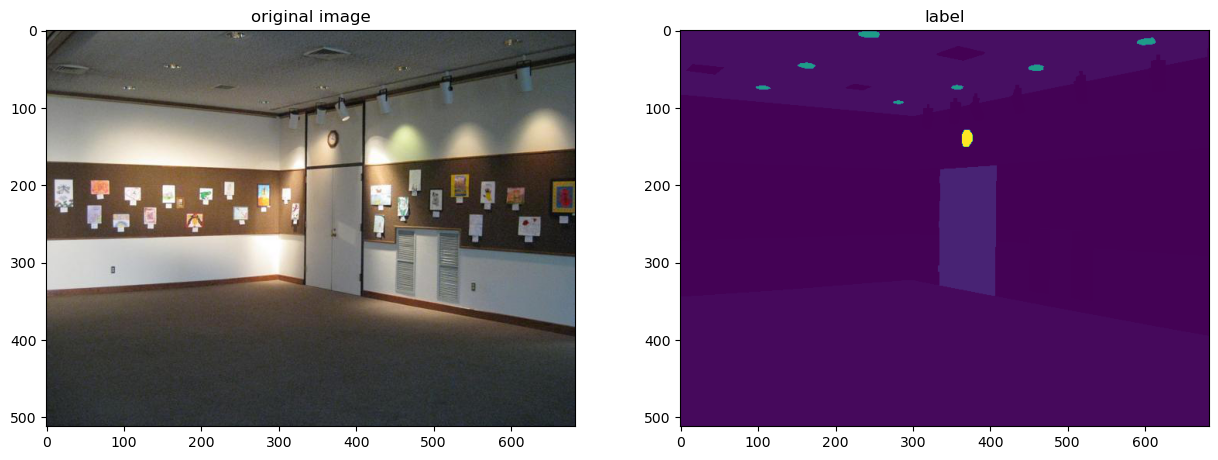

In [3]:
# 读取图片
idx = 2

img = ADE20KDataset.get_img_as_PIL(idx)
label = ADE20KDataset.get_label_as_PIL(idx)

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('original image')

plt.subplot(1, 2, 2)
plt.imshow(label)
plt.title('label')

plt.show()

In [4]:
print(type(label))

<class 'PIL.PngImagePlugin.PngImageFile'>


### 定义推理接口 inference_img(my_model, img_path) 返回logits

In [4]:
from tools import inference_img

img_path = str(ADE20KDataset.get_img_path(idx))

deeplabv3p_logits_res = inference_img(deeplabv3plus_model, img_path)[0]
pspnet_logits_res = inference_img(pspnet_model, img_path)[0]
fcn_logits_res = inference_img(fcn_model, img_path)[0]

In [19]:
deeplabv3p_logits_res.shape

torch.Size([150, 512, 683])

### 调用mmsegementation的推理接口，返回正常mask

In [5]:
import numpy as np
pspnet_result = inference_segmentor(pspnet_model, img_path)
fcn_result = inference_segmentor(fcn_model, img_path)
deeplabv3p_result = inference_segmentor(deeplabv3plus_model, img_path)
# show_result_pyplot(pspnet_model, img_path, result, get_palette('ade20k'))

pspnet_result = np.array(pspnet_result[0], dtype = np.uint8)
fcn_result = np.array(fcn_result[0], dtype = np.uint8)
deeplabv3p_result = np.array(deeplabv3p_result[0], dtype = np.uint8)

pspnet_result += 1
fcn_result += 1
deeplabv3p_result += 1

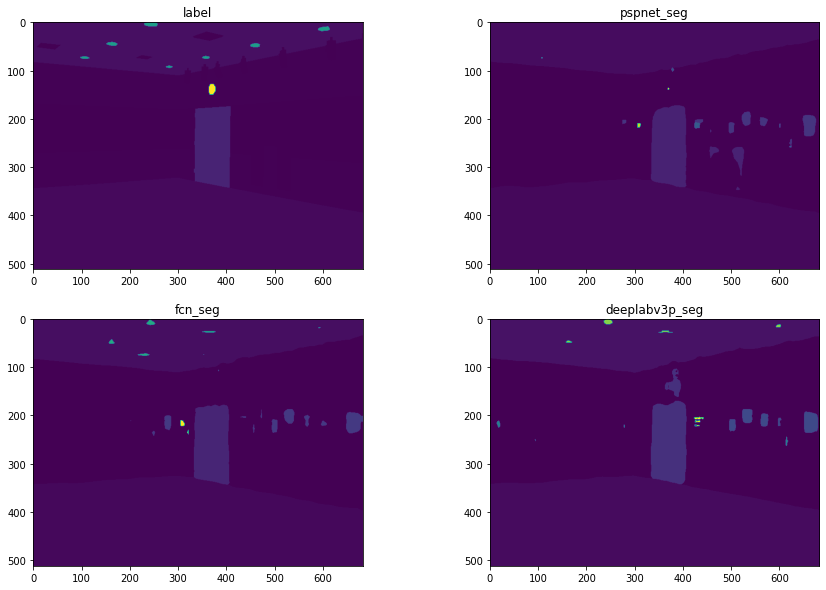

In [13]:
from PIL import Image
pspnet_seg = Image.fromarray(pspnet_result)
fcn_seg = Image.fromarray(fcn_result)
deeplabv3p_seg = Image.fromarray(deeplabv3p_result)

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.imshow(label)
plt.title('label')

plt.subplot(2, 2, 2)
plt.imshow(pspnet_seg)
plt.title('pspnet_seg')

plt.subplot(2, 2, 3)
plt.imshow(fcn_seg)
plt.title('fcn_seg')

plt.subplot(2, 2, 4)
plt.imshow(deeplabv3p_seg)
plt.title('deeplabv3p_seg')

plt.show()

### Major Vote

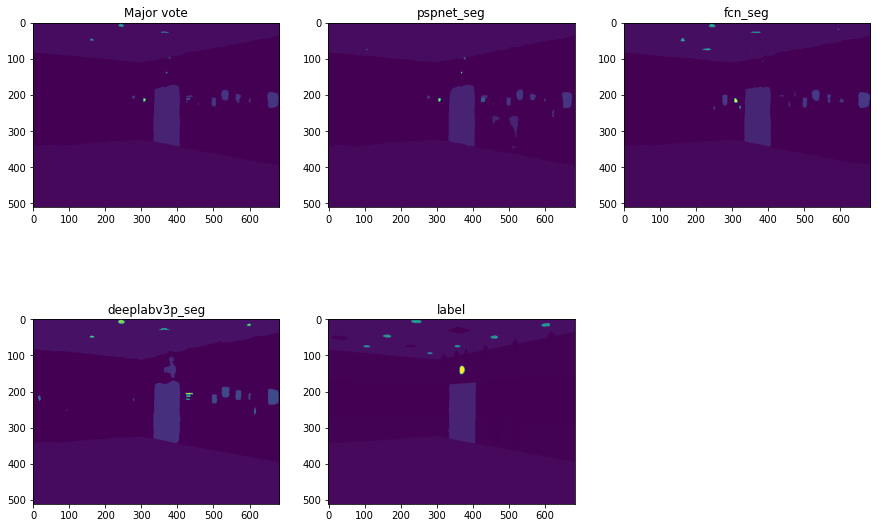

In [14]:
from tools import majorVote
fuse_res = majorVote(pspnet_result, fcn_result, deeplabv3p_result).astype(np.uint8)
fuse_seg = Image.fromarray(fuse_res)

plt.figure(figsize=(15,10))

plt.subplot(2, 3, 1)
plt.imshow(fuse_seg)
plt.title('Major vote')

plt.subplot(2, 3, 2)
plt.imshow(pspnet_seg)
plt.title('pspnet_seg')

plt.subplot(2, 3, 3)
plt.imshow(fcn_seg)
plt.title('fcn_seg')

plt.subplot(2, 3, 4)
plt.imshow(deeplabv3p_seg)
plt.title('deeplabv3p_seg')

plt.subplot(2, 3, 5)
plt.imshow(label)
plt.title('label')

plt.show()

### Mean IoU使用

In [29]:
from mmseg.core.evaluation import metrics

vote_IoU_result = metrics.mean_iou([label], [fuse_res], 150, 0)
fcn_IoU_result = metrics.mean_iou([label], [fcn_result], 150, 0)
deeplabv3p_IoU_result = metrics.mean_iou([label], [deeplabv3p_result], 150, 0)
pspnet_IoU_result = metrics.mean_iou([label], [pspnet_result], 150, 0)

In [30]:
print("Vote mIoU: " + str(np.nanmean(vote_IoU_result['IoU'])))
print("FCN mIoU: " + str(np.nanmean(fcn_IoU_result['IoU'])))
print("Deeplabv3plus mIoU: " + str(np.nanmean(deeplabv3p_IoU_result['IoU'])))
print("PSPnet mIoU: " + str(np.nanmean(pspnet_IoU_result['IoU'])))

Vote mIoU: 0.42173367045186766
FCN mIoU: 0.21363387276059348
Deeplabv3plus mIoU: 0.49818351423889734
PSPnet mIoU: 0.39927738581298505


### TODO：


*   三个模型的集成模型



### 定义Pytorch模型

In [6]:
from torch import nn
import torch.nn.functional as F
import torch

In [7]:

class FusionModel(nn.Module):
    '''
    输入: 三个模型的分割结果
    输出: 融合后的分割结果
    说明:
        每一个分割结果对应一个长度为150的向量, 每个向量的第i个元素表示第i类的权重
        三个分割结果的权重向量相加, 然后softmax, 得到最终的分割结果
    '''
    def __init__(self, class_num, device):
        super().__init__()
        # class_num: 150
        self.vec_1 = torch.from_numpy(np.random.rand(class_num)).reshape(class_num, 1, 1).to(device)
        self.vec_2 = torch.from_numpy(np.random.rand(class_num)).reshape(class_num, 1, 1).to(device)
        self.vec_3 = torch.from_numpy(np.random.rand(class_num)).reshape(class_num, 1, 1).to(device)
        
        self.Softmax = nn.Softmax()
        
    def forward(self, input_seg1, input_seg2, input_seg3):
        # input_seg size: (150, H, W)
        res_1 = input_seg1 * self.vec_1
        res_2 = input_seg2 * self.vec_2
        res_3 = input_seg3 * self.vec_3
        res = res_1 + res_2 + res_3
        # TODO: Softmax dim BUG HERE
        # res = self.Softmax(res, dim=0) 
        return res.argmax(0)


In [8]:
device = "cpu"

model = FusionModel(150,device)
model.to(device)
'''
Size: (150, H, W)
Name:
    deeplabv3p_logits_res
    pspnet_logits_res
    fcn_logits_res
'''
deeplabv3p_logits_res = deeplabv3p_logits_res.to(device)
pspnet_logits_res = pspnet_logits_res.to(device)
fcn_logits_res = fcn_logits_res.to(device)
res = model.forward(deeplabv3p_logits_res, pspnet_logits_res, fcn_logits_res)

In [9]:
res.argmax(0)

tensor([[5, 5, 5,  ..., 5, 5, 5],
        [5, 5, 5,  ..., 5, 5, 5],
        [5, 5, 5,  ..., 5, 5, 5],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]])

In [2]:
ADE20KDataset.get_img_name(0)

'ADE_train_00000001'